#               Final project G43 - matching the best model and data representation to solve a rubicks cube 

## the funnctions that we used to treat and generate the raw data 

In [1048]:

from random import choice
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import sklearn.tree        # For DecisionTreeClassifier class
import sklearn.ensemble    # For AdaBoostClassifier class
import sklearn.datasets    # For make_gaussian_quantiles
import sklearn.metrics 
import numpy as np
import pycuber as pc
import keras.backend as K
import numpy as np
import pickle
import keras 
from keras.layers import Dense , Dropout,Activation
import torch
from tqdm import tqdm


rotations = {'F': 0, 'B': 1, 'U': 2, 'D': 3, 'L': 4, 'R': 5, "F'": 6, "B'": 7, "U'": 8, "D'": 9, "L'": 10, "R'": 11,
              'F2': 12, 'B2': 13, 'U2': 14, 'D2': 15, 'L2': 16, 'R2': 17, "F2'": 18, "B2'": 19, "U2'": 20, "D2'": 21,
              "L2'": 22, "R2'": 23}

rotations_small = {'F': 0, 'B': 1, 'U': 2, 'D': 3, 'L': 4, 'R': 5, "F'": 6, "B'": 7, "U'": 8, "D'": 9, "L'": 10, "R'": 11}

inv_rotations = {v: k for k, v in rotations.items()}


color_map_hot = {'green': [1, 0, 0, 0, 0, 0], 'blue': [0, 1, 0, 0, 0, 0], 'yellow': [0, 0, 1, 0, 0, 0],
                  'red': [0, 0, 0, 1, 0, 0], 'orange': [0, 0, 0, 0, 1, 0], 'white': [0, 0, 0, 0, 0, 1]}
color_map_int = {'green':0, 'blue': 1, 'yellow': 2,
                  'red': 3, 'orange': 4, 'white': 5}


def flatten(cube):
    faces = [cube.F, cube.B, cube.U, cube.D, cube.L, cube.R]
    arr = []
    for x in faces:
        for i in range(3):
            for j in range(3):
                arr.append(x[i][j].colour)
    return arr
#print(flatten(pc.Cube()))


def flatten_hot(cube):
    faces = [cube.F, cube.B, cube.U, cube.D, cube.L, cube.R]
    arr = []
    for x in faces:
        for i in range(3):
            for j in range(3):
                arr.extend(color_map_hot[x[i][j].colour])
    return arr
#print(flatten_hot(pc.Cube()))


def flatten_int(cube):
    faces = [cube.F, cube.B, cube.U, cube.D, cube.L, cube.R]
    arr = []
    for x in faces:
        for i in range(3):
            for j in range(3):
                arr.append(color_map_int[x[i][j].colour])
    return arr
#print(flatten_int(pc.Cube()))

def face_val(data):
    if len(data) <= 1:
        return 0

    counts = Counter()

    for d in data:
        counts[d] += 1

    probs = [float(c) / len(data) for c in counts.values()]

    return max(probs)
def mean_faces(cube):
    flat = flatten(cube)
    perc_side = [face_val(flat[i:(i + 9)]) for i in range(0, 9 * 6, 9)]
  
    return np.mean(perc_side)

def gen_cube_hot(n_steps=6):
    cube = pc.Cube()
    transformation = [choice(list(rotations.keys())) for action in range(n_steps)]
    actions = pc.Formula(transformation)

    cube(actions)

    actions.reverse()

    X = []
    y = []
    cubes = []

    for s in actions:
        X.append(flatten_hot(cube))
        y.append(rotations[s.name])
        cubes.append(cube.copy())
        cube(s.name)

    return X,y,cubes

def gen_cube_int(n_steps=6):
    cube = pc.Cube()

    transformation = [choice(list(rotations.keys())) for action in range(n_steps)]

    actions = pc.Formula(transformation)

    cube(actions)

    actions.reverse()

    X = []
    y = []
    cubes = []

    for s in actions:
        X.append(flatten_int(cube))
        y.append(rotations[s.name])
        cubes.append(cube.copy())
        cube(s.name)

    return X,y,cubes


def gen_seq(n_steps=6):
    cube = pc.Cube()
    transformation = [choice(list(rotations.keys())) for action in range(n_steps)]
    actions = pc.Formula(transformation)
    cube(actions)
    actions.reverse()
    cubes = []
    moves_to_solve = []
    for i, s in enumerate(actions):
        cubes.append(cube.copy())
        cube(s.name)
        moves_to_solve.append(n_steps-i)

    return cubes, moves_to_solve


def next_states(cube, flatten_=flatten_hot):
  
    flats = []
    moves = []

    for a in rotations:
        cube_copy = cube.copy()
        cube_copy = cube_copy(a)
        flats.append(flatten_(cube_copy))
        moves.append(a)
       
    return flats, moves
print(next_states(pc.Cube())[1][3])


D


## More advanced function to generate the data and plot the results 

In [1132]:
def generate_flat_samples(n,flatten_=flatten_hot) : 
    CBS = []
    MSPS= []
    print('generating ' , n , ' samples')
    for j in tqdm(range(n)):
        CB, MSP = gen_seq(9)                
        CBS.extend(CB)
   
        MSPS.extend(MSP)
        CBS.append(pc.Cube())
        MSPS.extend([0])
    FCBS=[] 
    for c in CBS : 
        FCBS.append(flatten_(c))

    return FCBS,MSPS




def score_estimators(X, y, estimators):
    """Scores each estimator on (X, y), returning a list of scores."""
    # Your implementation here. Aim for 1-4 lines.
    arr=[]
    for each in estimators : 
        arr.append(each.score(X,y))
    return arr ;

def train_estimators(X, y, estimator_type, param_name, param_vals, **kwargs):
    arr=[]
    for param_val in param_vals :
        print('Training',estimator_type().__class__.__name__,'(',param_name,'=',param_val, kwargs    )
        obj = {param_name:param_val}
        estim=estimator_type(  **obj ,**kwargs).fit(X,y)
        arr.append(estim)
    return arr
def plot_estimator_scores(X,y,X2,y2,estimators, param_name, param_vals):
    paramss=param_vals
    param_vals=[1,2,3,4,5,6]
    maxtrn='train = ' , round(np.amax(score_estimators(X, y, estimators)),6)
    maxtst='test = ' ,round(np.amax(score_estimators(X2, y2, estimators)),6)
    plt.text(3.65, 0.32, maxtrn,c='g', fontsize=12)
    plt.text(3.65, 0.18,maxtst, fontsize=12)
    trn=plt.plot(param_vals, score_estimators(X, y, estimators) ,c='g',label="trn")
    tst= plt.plot(param_vals, score_estimators(X2, y2, estimators) ,c='black',linestyle =':' ,label="tst")
    plt.title(estimators[0].__class__.__name__ +'  score vs '+param_name)
    plt.xlabel(param_name)
    plt.ylabel("score")
    plt.legend( ["train ", "Validation","test"])
    plt.xticks([1,2,3,4,5,6],paramss)
    plt.yticks([0.0,0.2,0.4,0.6,0.8,1.0],[0.0,0.2,0.4,0.6,0.8,1.0])


# Generating the data

The run version is done with and input of 10 000 to the function that generate the data 
to see the functions running in a short time change the 10 000  to 10 and the 2000 to 2

In [1133]:
X_hot,y_hot=generate_flat_samples(10000)

X_int,y_int=generate_flat_samples(10000,flatten_=flatten_int)

tst_X_hot,tst_y_hot=generate_flat_samples(2000)

tst_X_int,tst_y_int=generate_flat_samples(2000,flatten_=flatten_int)


  0%|                                                                                | 5/10000 [00:00<03:43, 44.76it/s]

generating  10000  samples


  0%|                                                                                | 5/10000 [00:00<03:51, 43.22it/s]

generating  10000  samples


  0%|▏                                                                                | 5/2000 [00:00<00:40, 49.15it/s]

generating  2000  samples


  0%|▏                                                                                | 5/2000 [00:00<00:40, 48.67it/s]

generating  2000  samples


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:02<00:00, 31.80it/s]


Seeing the data shape 

In [1190]:
print(X_hot[0])
print(y_hot[0])


print(np.array(X_int[0]))
print(y_int[0])

print(X_int[10])
print(y_int[10])

[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
9
[3 3 4 1 0 1 2 4 2 2 0 2 

## Estimators 

### If you dowloaded the modesl just run this cell to load thme 

In [ ]:
tree_estimators_hot = pickle.load(open("tree_estimators_hot.sav", 'rb'))
tree_estimators_int = pickle.load(open("tree_estimators_int.sav", 'rb'))

forest_estimators_hot = pickle.load(open("forest_estimators_hot.sav", 'rb'))
forest_estimators_int = pickle.load(open("forest_estimators_int.sav", 'rb'))

logistic_estimators_hot = pickle.load(open("logistic_estimators_hot.sav", 'rb'))
logistic_estimators_int = pickle.load(open("logistic_estimators_int.sav", 'rb'))

SVC_estimator_hot = pickle.load(open("SVC_estimator_hot.sav", 'rb'))
SVC_estimator_int = pickle.load(open("SVC_estimator_int.sav", 'rb'))

adaclassifier_estimators_hot = pickle.load(open("adaclassifier_estimators_hot.sav", 'rb'))
adaclassifier_estimators_int = pickle.load(open("adaclassifier_estimators_int.sav", 'rb'))

GradientBoosting_estimators_hot = pickle.load(open("GradientBoosting_estimators_hot.sav", 'rb'))
GradientBoosting_estimators_int = pickle.load(open("GradientBoosting_estimators_int.sav", 'rb'))

### TREE ESTIMATORS

In [1135]:
tree_estimators_hot = train_estimators(X_hot, y_hot, sklearn.tree.DecisionTreeClassifier,
                                   'max_depth', [1,5, 10,30,50,100], splitter='random', random_state=0)
tree_estimators_int = train_estimators(X_int, y_int, sklearn.tree.DecisionTreeClassifier,
                                   'max_depth', [1,5, 10,30,50,100], splitter='random', random_state=0)
print(tree_estimators_int[0].predict(np.array(flatten_int( pc.Cube() )).reshape(1,-1)))


Training DecisionTreeClassifier ( max_depth = 1 {'splitter': 'random', 'random_state': 0}
Training DecisionTreeClassifier ( max_depth = 5 {'splitter': 'random', 'random_state': 0}
Training DecisionTreeClassifier ( max_depth = 10 {'splitter': 'random', 'random_state': 0}
Training DecisionTreeClassifier ( max_depth = 30 {'splitter': 'random', 'random_state': 0}
Training DecisionTreeClassifier ( max_depth = 50 {'splitter': 'random', 'random_state': 0}
Training DecisionTreeClassifier ( max_depth = 100 {'splitter': 'random', 'random_state': 0}
Training DecisionTreeClassifier ( max_depth = 1 {'splitter': 'random', 'random_state': 0}
Training DecisionTreeClassifier ( max_depth = 5 {'splitter': 'random', 'random_state': 0}
Training DecisionTreeClassifier ( max_depth = 10 {'splitter': 'random', 'random_state': 0}
Training DecisionTreeClassifier ( max_depth = 30 {'splitter': 'random', 'random_state': 0}
Training DecisionTreeClassifier ( max_depth = 50 {'splitter': 'random', 'random_state': 0}
Tr

Saving the model

In [1139]:
filename = 'tree_estimators_hot.sav'
pickle.dump(tree_estimators_hot, open(filename, 'wb'))
filename = 'tree_estimators_int.sav'
pickle.dump(tree_estimators_int, open(filename, 'wb'))

Plotting the results

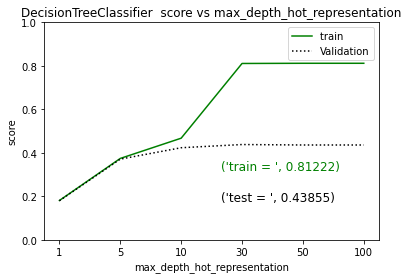

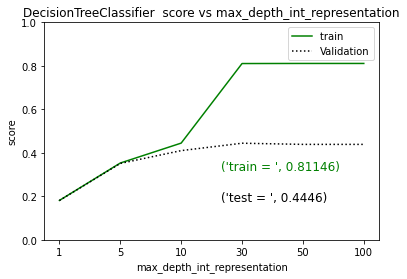

In [1137]:


plot_estimator_scores(X_hot,y_hot,tst_X_hot,tst_y_hot,tree_estimators_hot, 'max_depth_hot_representation', [1,5, 10,30,50,100])
plt.figure()
plot_estimator_scores(X_int,y_int,tst_X_int, tst_y_int,tree_estimators_int, 'max_depth_int_representation', [1,5, 10,30,50,100])

# Forest ESTIMATORS

In [1138]:


forest_estimators_hot = train_estimators(X_hot, y_hot, sklearn.ensemble.RandomForestClassifier,
                   
                                   'max_depth', [1, 5, 10,20,50,100])
forest_estimators_int = train_estimators(X_int, y_int, sklearn.ensemble.RandomForestClassifier,
                   
                                   'max_depth', [1, 5, 10,20,50,100])



Training RandomForestClassifier ( max_depth = 1 {}
Training RandomForestClassifier ( max_depth = 5 {}
Training RandomForestClassifier ( max_depth = 10 {}
Training RandomForestClassifier ( max_depth = 20 {}
Training RandomForestClassifier ( max_depth = 50 {}
Training RandomForestClassifier ( max_depth = 100 {}
Training RandomForestClassifier ( max_depth = 1 {}
Training RandomForestClassifier ( max_depth = 5 {}
Training RandomForestClassifier ( max_depth = 10 {}
Training RandomForestClassifier ( max_depth = 20 {}
Training RandomForestClassifier ( max_depth = 50 {}
Training RandomForestClassifier ( max_depth = 100 {}


Saving the model

In [1140]:
filename = 'forest_estimators_hot.sav'
pickle.dump(forest_estimators_hot, open(filename, 'wb'))

filename = 'forest_estimators_int.sav'
pickle.dump(forest_estimators_int, open(filename, 'wb'))

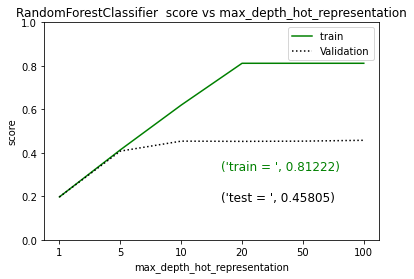

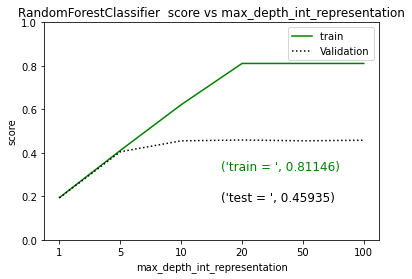

In [1141]:

plot_estimator_scores(X_hot,y_hot,tst_X_hot,tst_y_hot,forest_estimators_hot, 'max_depth_hot_representation', [1, 5, 10,20,50,100])
plt.figure()
plot_estimator_scores(X_int,y_int,tst_X_int, tst_y_int,forest_estimators_int, 'max_depth_int_representation', [1, 5, 10,20,50,100])


#   LOGISITIC REGRESSION

In [1142]:
logistic_estimators_hot = train_estimators(X_hot, y_hot, sklearn.linear_model.LogisticRegression,
                                   'C', [1e-05,0.0001, 0.001,0.01,0.1,1],max_iter=10000, random_state=0)
logistic_estimators_int = train_estimators(X_int, y_int, sklearn.linear_model.LogisticRegression,
                                   'C', [1e-05,0.0001, 0.001,0.01,0.1,1],max_iter=10000, random_state=0)



Training LogisticRegression ( C = 1e-05 {'max_iter': 10000, 'random_state': 0}
Training LogisticRegression ( C = 0.0001 {'max_iter': 10000, 'random_state': 0}
Training LogisticRegression ( C = 0.001 {'max_iter': 10000, 'random_state': 0}
Training LogisticRegression ( C = 0.01 {'max_iter': 10000, 'random_state': 0}
Training LogisticRegression ( C = 0.1 {'max_iter': 10000, 'random_state': 0}
Training LogisticRegression ( C = 1 {'max_iter': 10000, 'random_state': 0}
Training LogisticRegression ( C = 1e-05 {'max_iter': 10000, 'random_state': 0}
Training LogisticRegression ( C = 0.0001 {'max_iter': 10000, 'random_state': 0}
Training LogisticRegression ( C = 0.001 {'max_iter': 10000, 'random_state': 0}
Training LogisticRegression ( C = 0.01 {'max_iter': 10000, 'random_state': 0}
Training LogisticRegression ( C = 0.1 {'max_iter': 10000, 'random_state': 0}
Training LogisticRegression ( C = 1 {'max_iter': 10000, 'random_state': 0}


Saving the model

In [1143]:
filename = 'logistic_estimators_hot.sav'
pickle.dump(logistic_estimators_hot, open(filename, 'wb'))
    
filename = 'logistic_estimators_int.sav'
pickle.dump(logistic_estimators_int, open(filename, 'wb'))

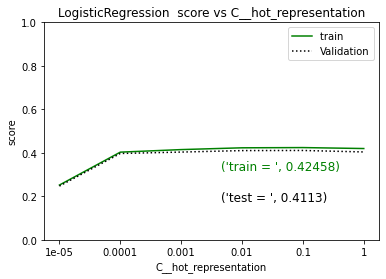

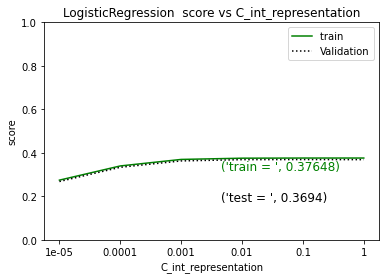

In [1144]:

plot_estimator_scores(X_hot,y_hot,tst_X_hot,tst_y_hot,logistic_estimators_hot, 'C__hot_representation',[1e-05,0.0001, 0.001,0.01,0.1,1])
plt.figure()
plot_estimator_scores(X_int,y_int,tst_X_int, tst_y_int,logistic_estimators_int, 'C_int_representation', [1e-05,0.0001, 0.001,0.01,0.1,1])

# SVC

In [530]:

# Your code here. Aim for 1-2 lines.
SVC_estimator_hot = train_estimators(X_hot, y_hot, sklearn.svm.SVC,
                                   'C', [0.01,0.1, 1, 10, 100 ,1000], gamma=0.001, max_iter=1000, random_state=0)
SVC_estimator_int = train_estimators(X_int, y_int, sklearn.svm.SVC,
                                   'C', [0.01,0.1, 1, 10, 100 ,1000], gamma=0.001, max_iter=1000, random_state=0)



Training SVC ( C = 0.01 {'gamma': 0.001, 'max_iter': 1000, 'random_state': 0}


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Training SVC ( C = 0.1 {'gamma': 0.001, 'max_iter': 1000, 'random_state': 0}


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Training SVC ( C = 1 {'gamma': 0.001, 'max_iter': 1000, 'random_state': 0}


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Training SVC ( C = 10 {'gamma': 0.001, 'max_iter': 1000, 'random_state': 0}


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Training SVC ( C = 100 {'gamma': 0.001, 'max_iter': 1000, 'random_state': 0}


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Training SVC ( C = 1000 {'gamma': 0.001, 'max_iter': 1000, 'random_state': 0}


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Training SVC ( C = 0.01 {'gamma': 0.001, 'max_iter': 1000, 'random_state': 0}


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Training SVC ( C = 0.1 {'gamma': 0.001, 'max_iter': 1000, 'random_state': 0}


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Training SVC ( C = 1 {'gamma': 0.001, 'max_iter': 1000, 'random_state': 0}


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Training SVC ( C = 10 {'gamma': 0.001, 'max_iter': 1000, 'random_state': 0}


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Training SVC ( C = 100 {'gamma': 0.001, 'max_iter': 1000, 'random_state': 0}


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Training SVC ( C = 1000 {'gamma': 0.001, 'max_iter': 1000, 'random_state': 0}


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Wall time: 20min 38s


Saving the model

In [1102]:
filename = 'SVC_estimator_hot.sav'
pickle.dump(SVC_estimator_hot, open(filename, 'wb'))

filename = 'SVC_estimator_int.sav'
pickle.dump(SVC_estimator_hot, open(filename, 'wb'))

Wall time: 18min 17s


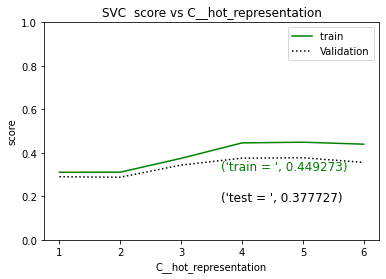

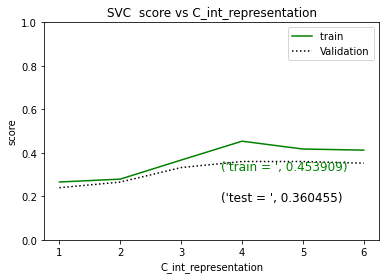

In [531]:

plot_estimator_scores(X_hot,y_hot,tst_X_hot,tst_y_hot,SVC_estimator_hot, 'C__hot_representation',[0.01,0.1, 1, 10, 100 ,1000])
plt.figure() 
plot_estimator_scores(X_int,y_int,tst_X_int, tst_y_int,SVC_estimator_int, 'C_int_representation', [0.01,0.1, 1, 10, 100 ,1000])


# adaboost

In [1145]:

adaclassifier_estimators_hot= train_estimators(X_hot, y_hot, sklearn.ensemble.AdaBoostClassifier,
                        'learning_rate', [0.0001,0.001, 0.01, 0.1, 1 ,10],n_estimators=100 )

adaclassifier_estimators_int = train_estimators(X_int, y_int, sklearn.ensemble.AdaBoostClassifier,
                        'learning_rate', [0.0001,0.001, 0.01, 0.1, 1 ,10],n_estimators=100 )



Training AdaBoostClassifier ( learning_rate = 0.0001 {'n_estimators': 100}
Training AdaBoostClassifier ( learning_rate = 0.001 {'n_estimators': 100}
Training AdaBoostClassifier ( learning_rate = 0.01 {'n_estimators': 100}
Training AdaBoostClassifier ( learning_rate = 0.1 {'n_estimators': 100}
Training AdaBoostClassifier ( learning_rate = 1 {'n_estimators': 100}
Training AdaBoostClassifier ( learning_rate = 10 {'n_estimators': 100}
Training AdaBoostClassifier ( learning_rate = 0.0001 {'n_estimators': 100}
Training AdaBoostClassifier ( learning_rate = 0.001 {'n_estimators': 100}
Training AdaBoostClassifier ( learning_rate = 0.01 {'n_estimators': 100}
Training AdaBoostClassifier ( learning_rate = 0.1 {'n_estimators': 100}
Training AdaBoostClassifier ( learning_rate = 1 {'n_estimators': 100}
Training AdaBoostClassifier ( learning_rate = 10 {'n_estimators': 100}


Saving the model

In [1149]:
filename = 'adaclassifier_estimators_hot.sav'
pickle.dump(adaclassifier_estimators_hot, open(filename, 'wb'))

filename = 'adaclassifier_estimators_int.sav'
pickle.dump(adaclassifier_estimators_int, open(filename, 'wb'))

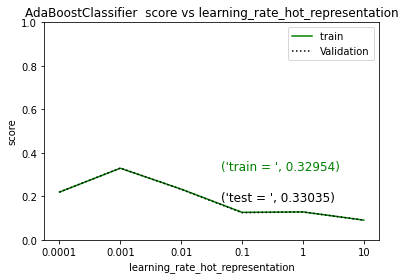

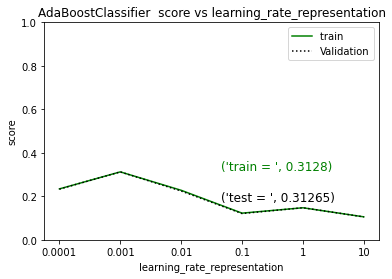

In [1150]:

plot_estimator_scores(X_hot,y_hot,tst_X_hot,tst_y_hot,adaclassifier_estimators_hot, 'learning_rate_hot_representation'
                      , [0.0001,0.001, 0.01, 0.1, 1 ,10])
plt.figure() 
plot_estimator_scores(X_int,y_int,tst_X_int, tst_y_int,adaclassifier_estimators_int, 'learning_rate_representation',
                      [0.0001,0.001, 0.01, 0.1, 1 ,10])


# GRADIENT BOOSTING  CLASSIFIER

In [1148]:

 
GradientBoosting_estimators_hot= train_estimators(X_hot, y_hot, sklearn.ensemble.GradientBoostingClassifier,
                        'learning_rate', [0.0001,0.001, 0.01, 0.1, 1 ,10],n_estimators=100 )

GradientBoosting_estimators_int = train_estimators(X_int, y_int, sklearn.ensemble.GradientBoostingClassifier,
                        'learning_rate', [0.0001,0.001, 0.01, 0.1, 1 ,10],n_estimators=100 )



Training GradientBoostingClassifier ( learning_rate = 0.0001 {'n_estimators': 100}
Training GradientBoostingClassifier ( learning_rate = 0.001 {'n_estimators': 100}
Training GradientBoostingClassifier ( learning_rate = 0.01 {'n_estimators': 100}
Training GradientBoostingClassifier ( learning_rate = 0.1 {'n_estimators': 100}
Training GradientBoostingClassifier ( learning_rate = 1 {'n_estimators': 100}
Training GradientBoostingClassifier ( learning_rate = 10 {'n_estimators': 100}
Training GradientBoostingClassifier ( learning_rate = 0.0001 {'n_estimators': 100}
Training GradientBoostingClassifier ( learning_rate = 0.001 {'n_estimators': 100}
Training GradientBoostingClassifier ( learning_rate = 0.01 {'n_estimators': 100}
Training GradientBoostingClassifier ( learning_rate = 0.1 {'n_estimators': 100}
Training GradientBoostingClassifier ( learning_rate = 1 {'n_estimators': 100}
Training GradientBoostingClassifier ( learning_rate = 10 {'n_estimators': 100}


Saving the model

In [1151]:
filename = 'GradientBoosting_estimators_hot.sav'
pickle.dump(GradientBoosting_estimators_hot, open(filename, 'wb'))

filename = 'GradientBoosting_estimators_int.sav'
pickle.dump(GradientBoosting_estimators_int, open(filename, 'wb'))
print('done')

done


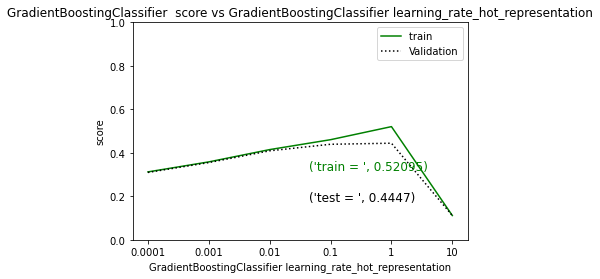

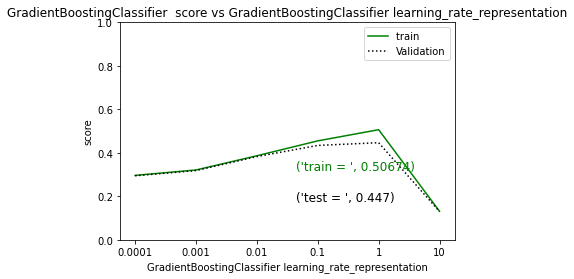

In [1152]:

plot_estimator_scores(X_hot,y_hot,tst_X_hot,tst_y_hot,GradientBoosting_estimators_hot, 'GradientBoostingClassifier learning_rate_hot_representation', [0.0001,0.001, 0.01, 0.1, 1 ,10])
plt.figure() 
plot_estimator_scores(X_int,y_int,tst_X_int, tst_y_int,GradientBoosting_estimators_int, 'GradientBoostingClassifier learning_rate_representation', [0.0001,0.001, 0.01, 0.1, 1 ,10])


# TESTING ON A RANDOM CUBE

In [1107]:
cube,_=gen_seq(n_steps=5)
print([cube[0]])
cubes=pc.Cube()


[            
            
            
                        
                        
                        
            
            
            
]


In [1108]:
def get_solution(estimator,cubea,shape='hot'): 
    cube=cubea.copy()
    print('estimated number of moves is ',estimator.predict(np.array(flatten_hot(cube)).reshape(1,-1))[0] )

    if (mean_faces(cube)==1):
        return [] ;
    solution=[]
    min_moves=100
    val=[]
    for _ in range(30) :

        previsions,moves=next_states(cube, flatten_=flatten_hot)
        if(_>0):
            
            print(moves[val.index(min(val))])
            if (moves[val.index(min(val))][ len( moves[val.index(min(val))]) -1 ]!="'" ) :
                rep=moves.index(moves[val.index(min(val))]+str("'"))
                moves.pop(rep)
                previsions.pop(rep)
                
            else  :
                
                rep=moves.index(moves[val.index(min(val))].replace("'", ''))
                moves.pop(rep)
                previsions.pop(rep)

        val=[]
  
        for i in range (0,len(previsions)) : 
            nbr=estimator.predict(np.array(previsions[i]).reshape(1,-1))
            val.append(nbr[0])
        
        print(val)
        solution.append(moves[val.index(min(val))])
        cube=cube(moves[val.index(min(val))])
        if (min(val)==0):
            return solution ;   
    return solution ;



a=get_solution(forest_estimators_hot[4],cube[0])

print(a)

estimated number of moves is  6
[8, 9, 6, 9, 6, 8, 8, 9, 7, 9, 9, 7, 9, 9, 5, 4, 8, 9, 9, 9, 5, 4, 8, 9]
D2
[9, 7, 4, 9, 7, 5, 9, 9, 8, 9, 8, 5, 9, 9, 3, 6, 6, 9, 9, 9, 3, 6, 9]
U2
[9, 7, 8, 8, 2, 4, 7, 5, 4, 6, 3, 5, 6, 5, 4, 5, 3, 6, 6, 5, 5, 3, 6]
L
[4, 7, 1, 3, 3, 5, 3, 3, 2, 6, 3, 3, 3, 2, 3, 3, 5, 3, 3, 2, 3, 3, 5]
U
[2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0]
['D2', 'U2', 'L', 'U', 'R2']


In [1109]:
## print([cube[0]])
cuba=cube[0].copy()
for i in a :
    print(' ')
    print([cuba(i)])

 
[            
            
            
                        
                        
                        
            
            
            
]
 
[            
            
            
                        
                        
                        
            
            
            
]
 
[            
            
            
                        
                        
                        
            
            
            
]
 
[            
            
            
                        
                        
                        
            
            
            
]
 
[            
            
            
                        
                        
                        
            
            
            
]


## Training the neural networks 

In [1175]:
nn_hot=[]
nn_int=[]
for i in range(0,6): 
    nn_hot.append( keras.models.load_model('nn_hot'+str(i)+'.sav'))
    nn_int.append( keras.models.load_model('nn_int'+str(i)+'.sav'))

OSError: SavedModel file does not exist at: nn_int0.sav/{saved_model.pbtxt|saved_model.pb}

In [1182]:

def get_model(lr=0.0001):
    input1 = Input((324,))

    d1 = Dense(1024)
    d2 = Dense(1024)
    d3 = Dense(1024)

    d4 = Dense(50)

    x1 = d1(input1)
    x1 = LeakyReLU()(x1)
    x1 = d2(x1)
    x1 = LeakyReLU()(x1)
    x1 = d3(x1)
    x1 = LeakyReLU()(x1)
    x1 = d4(x1)
    x1 = LeakyReLU()(x1)


    out_policy = Dense(len(rotations), activation="softmax")(x1)

    model = Model(input1, out_policy)

    model.compile(loss= 'sparse_categorical_crossentropy', optimizer=Adam(lr),
                  metrics='accuracy')
    model.summary()

    return model

nn_hot=[]
history_hot=[]
learn=[0.00001,0.0001,0.001,0.01,1,10]
j=0
for i in learn :

    nn_hot.append(get_model(lr=i))
    history_hot.append(nn_hot[j].fit(X_hot,y_hot,verbose=1,batch_size=1000,epochs=10))
    j+=1

Model: "functional_211"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_126 (InputLayer)       [(None, 324)]             0         
_________________________________________________________________
dense_802 (Dense)            (None, 1024)              332800    
_________________________________________________________________
leaky_re_lu_384 (LeakyReLU)  (None, 1024)              0         
_________________________________________________________________
dense_803 (Dense)            (None, 1024)              1049600   
_________________________________________________________________
leaky_re_lu_385 (LeakyReLU)  (None, 1024)              0         
_________________________________________________________________
dense_804 (Dense)            (None, 1024)              1049600   
_________________________________________________________________
leaky_re_lu_386 (LeakyReLU)  (None, 1024)           

Epoch 1/10
100/100 [==============================] - 10s 101ms/step - loss: 13.7810 - accuracy: 0.2888
Epoch 2/10
100/100 [==============================] - 10s 100ms/step - loss: 1.4645 - accuracy: 0.4208
Epoch 3/10
100/100 [==============================] - 10s 100ms/step - loss: 1.4317 - accuracy: 0.4376
Epoch 4/10
100/100 [==============================] - 10s 101ms/step - loss: 1.4191 - accuracy: 0.4413
Epoch 5/10
100/100 [==============================] - 11s 109ms/step - loss: 1.3922 - accuracy: 0.4518
Epoch 6/10
100/100 [==============================] - 10s 104ms/step - loss: 1.3770 - accuracy: 0.4579
Epoch 7/10
100/100 [==============================] - 11s 107ms/step - loss: 1.3740 - accuracy: 0.4590
Epoch 8/10
100/100 [==============================] - 11s 109ms/step - loss: 1.3496 - accuracy: 0.4657
Epoch 9/10
100/100 [==============================] - 11s 109ms/step - loss: 1.3378 - accuracy: 0.4722
Epoch 10/10
100/100 [==============================] - 10s 103ms/step - 

Saving the model

In [1183]:
filename = 'nn_hot'
for i in range(0,len(nn_hot)):
    nn_hot[i].save(filename+str(i)+'.sav')
    with open('trainHistoryDict_hot'+str(i), 'wb') as file_pi:
        pickle.dump(history_hot[i].history, file_pi)


INFO:tensorflow:Assets written to: nn_hot0.sav\assets
INFO:tensorflow:Assets written to: nn_hot1.sav\assets
INFO:tensorflow:Assets written to: nn_hot2.sav\assets
INFO:tensorflow:Assets written to: nn_hot3.sav\assets
INFO:tensorflow:Assets written to: nn_hot4.sav\assets
INFO:tensorflow:Assets written to: nn_hot5.sav\assets


In [1184]:

def get_model(lr=0.0001):
    input1 = Input((54,))

    d1 = Dense(1024)
    d2 = Dense(1024)
    d3 = Dense(1024)

    d4 = Dense(50)

    x1 = d1(input1)
    x1 = LeakyReLU()(x1)
    x1 = d2(x1)
    x1 = LeakyReLU()(x1)
    x1 = d3(x1)
    x1 = LeakyReLU()(x1)
    x1 = d4(x1)
    x1 = LeakyReLU()(x1)


    out_policy = Dense(len(rotations), activation="softmax")(x1)

    model = Model(input1, out_policy)

    model.compile(loss= 'sparse_categorical_crossentropy', optimizer=Adam(lr),
                  metrics='accuracy')
    model.summary()
    
    return model

nn_int=[]
history_int=[]
learn=[0.00001,0.0001,0.001,0.01,1,10]
j=0
for i in learn :

    nn_int.append(get_model(lr=i))
    history_int.append(nn_int[j].fit(X_int,y_int,verbose=1,batch_size=1000,epochs=10 ))
    j+=1



Model: "functional_223"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_132 (InputLayer)       [(None, 54)]              0         
_________________________________________________________________
dense_832 (Dense)            (None, 1024)              56320     
_________________________________________________________________
leaky_re_lu_408 (LeakyReLU)  (None, 1024)              0         
_________________________________________________________________
dense_833 (Dense)            (None, 1024)              1049600   
_________________________________________________________________
leaky_re_lu_409 (LeakyReLU)  (None, 1024)              0         
_________________________________________________________________
dense_834 (Dense)            (None, 1024)              1049600   
_________________________________________________________________
leaky_re_lu_410 (LeakyReLU)  (None, 1024)           

Epoch 1/10
100/100 [==============================] - 10s 97ms/step - loss: 61.2537 - accuracy: 0.1394
Epoch 2/10
100/100 [==============================] - 10s 96ms/step - loss: 1.7256 - accuracy: 0.3517
Epoch 3/10
100/100 [==============================] - 10s 96ms/step - loss: 1.5843 - accuracy: 0.3821
Epoch 4/10
100/100 [==============================] - 10s 97ms/step - loss: 1.5711 - accuracy: 0.3850
Epoch 5/10
100/100 [==============================] - 10s 100ms/step - loss: 1.5401 - accuracy: 0.3979
Epoch 6/10
100/100 [==============================] - 10s 99ms/step - loss: 1.5308 - accuracy: 0.4016
Epoch 7/10
100/100 [==============================] - 10s 99ms/step - loss: 1.5242 - accuracy: 0.4031
Epoch 8/10
100/100 [==============================] - 10s 96ms/step - loss: 1.5069 - accuracy: 0.4098
Epoch 9/10
100/100 [==============================] - 10s 97ms/step - loss: 1.4993 - accuracy: 0.4132
Epoch 10/10
100/100 [==============================] - 10s 96ms/step - loss: 1.4

Saving the model

In [1185]:
filename = 'nn_int'
for i in range(0,len(nn_int)):
    nn_int[i].save(filename+str(i)+'.sav')
    with open('trainHistoryDict'+str(i), 'wb') as file_pi:
        pickle.dump(history_int[i].history, file_pi)

INFO:tensorflow:Assets written to: nn_int0.sav\assets
INFO:tensorflow:Assets written to: nn_int1.sav\assets
INFO:tensorflow:Assets written to: nn_int2.sav\assets
INFO:tensorflow:Assets written to: nn_int3.sav\assets
INFO:tensorflow:Assets written to: nn_int4.sav\assets
INFO:tensorflow:Assets written to: nn_int5.sav\assets


Text(0, 0.5, 'accuracy')

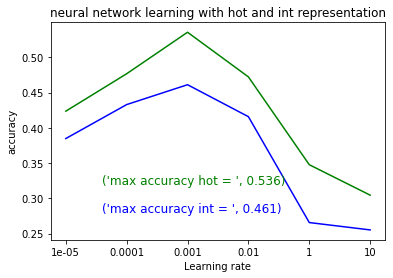

In [1186]:

plot_hot=[]
for i in  history_hot : 
    plot_hot.append(max(i.history['accuracy']))
plot_int=[]

for i in  history_int : 
    plot_int.append(max(i.history['accuracy']))
param_vals=[1,2,3,4,5,6]
maxtrn='max accuracy int = ' ,round(max(plot_int),3)
plt.text(1.6, 0.28, maxtrn,c='b', fontsize=12)
trn=plt.plot(param_vals, plot_int ,c='b',label="trn")
maxtrn='max accuracy hot = ' ,round(max(plot_hot),3)
plt.text(1.6, 0.32, maxtrn,c='g', fontsize=12)
trn=plt.plot(param_vals, plot_hot ,c='g',label="trn")
plt.title('neural network learning with hot and int representation')
plt.xticks([1,2,3,4,5,6],[0.00001,0.0001,0.001,0.01,1,10])
plt.xlabel('Learning rate')
plt.ylabel("accuracy")

In [1187]:

def get_model(lr=0.0001):


    model = keras.Sequential()
    model.add( Dense(1024 ,input_shape=(324,) ))
    model.add( Dense(1024, activation="relu") )
    model.add( Dense(50, activation="relu") )
    model.add( Dense(len(rotations), activation="softmax") )


    model.compile(loss= 'sparse_categorical_crossentropy', optimizer=Adam(lr),
                  metrics='accuracy')
    model.summary()

    return model

nn2_hot=[]
history2_hot=[]
learn=[0.00001,0.0001,0.001,0.01,1,10]
j=0
for i in learn :

    nn2_hot.append(get_model(lr=i))
    history2_hot.append(nn2_hot[j].fit(X_hot,y_hot,verbose=1,batch_size=1000,epochs=10))
    j+=1

Model: "sequential_96"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_862 (Dense)            (None, 1024)              332800    
_________________________________________________________________
dense_863 (Dense)            (None, 1024)              1049600   
_________________________________________________________________
dense_864 (Dense)            (None, 50)                51250     
_________________________________________________________________
dense_865 (Dense)            (None, 24)                1224      
Total params: 1,434,874
Trainable params: 1,434,874
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
100/100 [==============================] - 7s 69ms/step - loss: 2.8830 - accuracy: 0.1841
Epoch 2/10
100/100 [==============================] - 7s 69ms/step - loss: 2.3742 - accuracy: 0.3131
Epoch 3/10
100/100 [===================

Epoch 1/10
100/100 [==============================] - 6s 59ms/step - loss: 301196.5625 - accuracy: 0.0990
Epoch 2/10
100/100 [==============================] - 6s 58ms/step - loss: 2.3076 - accuracy: 0.0991 1s - loss: 2.3073 
Epoch 3/10
100/100 [==============================] - 6s 58ms/step - loss: 2.3083 - accuracy: 0.0997
Epoch 4/10
100/100 [==============================] - 6s 59ms/step - loss: 2.3083 - accuracy: 0.0992
Epoch 5/10
100/100 [==============================] - 6s 58ms/step - loss: 2.3097 - accuracy: 0.1011
Epoch 6/10
100/100 [==============================] - 6s 58ms/step - loss: 2.3105 - accuracy: 0.0995
Epoch 7/10
100/100 [==============================] - 6s 58ms/step - loss: 2.3099 - accuracy: 0.0996
Epoch 8/10
100/100 [==============================] - 6s 58ms/step - loss: 2.3114 - accuracy: 0.0993 0s - loss: 2.3113 - accu
Epoch 9/10
100/100 [==============================] - 6s 58ms/step - loss: 2.3100 - accuracy: 0.1019
Epoch 10/10
100/100 [=====================

In [1188]:
def get_model(lr=0.0001):


    model = keras.Sequential()
    model.add( Dense(1024 ,input_shape=(54,) ))
    model.add( Dense(1024, activation="relu") )
    model.add( Dense(50, activation="relu") )
    model.add( Dense(len(rotations), activation="softmax") )


    model.compile(loss= 'sparse_categorical_crossentropy', optimizer=Adam(lr),
                  metrics='accuracy')
    model.summary()

    return model

nn2_int=[]
history2_int=[]
learn=[0.00001,0.0001,0.001,0.01,1,10]
j=0
for i in learn :

    nn2_int.append(get_model(lr=i))
    history2_int.append(nn2_int[j].fit(X_int,y_int,verbose=1,batch_size=1000,epochs=10))
    j+=1

Model: "sequential_102"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_886 (Dense)            (None, 1024)              56320     
_________________________________________________________________
dense_887 (Dense)            (None, 1024)              1049600   
_________________________________________________________________
dense_888 (Dense)            (None, 50)                51250     
_________________________________________________________________
dense_889 (Dense)            (None, 24)                1224      
Total params: 1,158,394
Trainable params: 1,158,394
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
100/100 [==============================] - 6s 63ms/step - loss: 2.7805 - accuracy: 0.1438
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 2.2768 - accuracy: 0.21 - 6s 63ms/step - loss: 2.2768 - accuracy: 0.2

Epoch 1/10
100/100 [==============================] - 6s 59ms/step - loss: 6056709.5000 - accuracy: 0.0985
Epoch 2/10
100/100 [==============================] - 6s 59ms/step - loss: 2.3108 - accuracy: 0.1003
Epoch 3/10
100/100 [==============================] - 6s 56ms/step - loss: 2.3106 - accuracy: 0.0999
Epoch 4/10
100/100 [==============================] - 5s 55ms/step - loss: 2.3095 - accuracy: 0.1008
Epoch 5/10
100/100 [==============================] - 6s 56ms/step - loss: 2.3111 - accuracy: 0.1007
Epoch 6/10
100/100 [==============================] - 5s 54ms/step - loss: 2.3143 - accuracy: 0.1017
Epoch 7/10
100/100 [==============================] - 5s 54ms/step - loss: 2.3141 - accuracy: 0.0994
Epoch 8/10
100/100 [==============================] - 5s 54ms/step - loss: 2.3166 - accuracy: 0.0991
Epoch 9/10
100/100 [==============================] - 5s 54ms/step - loss: 2.3120 - accuracy: 0.1007
Epoch 10/10
100/100 [==============================] - 5s 54ms/step - loss: 2.3156 - 

Text(0, 0.5, 'accuracy')

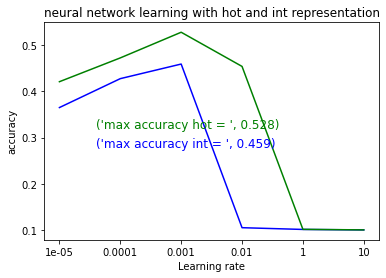

In [1189]:

plot_hot=[]
for i in  history2_hot : 
    plot_hot.append(max(i.history['accuracy']))
plot_int=[]
for i in  history2_int : 
    plot_int.append(max(i.history['accuracy']))
param_vals=[1,2,3,4,5,6]
maxtrn='max accuracy int = ' ,round(max(plot_int),3)
plt.text(1.6, 0.28, maxtrn,c='b', fontsize=12)
trn=plt.plot(param_vals, plot_int ,c='b',label="trn")
maxtrn='max accuracy hot = ' ,round(max(plot_hot),3)
plt.text(1.6, 0.32, maxtrn,c='g', fontsize=12)
trn=plt.plot(param_vals, plot_hot ,c='g',label="trn")
plt.title('neural network learning with hot and int representation')
plt.xticks([1,2,3,4,5,6],[0.00001,0.0001,0.001,0.01,1,10])
plt.xlabel('Learning rate')
plt.ylabel("accuracy")